<a href="https://colab.research.google.com/github/Andreas-Lukito/Medzy_ocr/blob/main/medzy_hyperopt_colab_ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medzy

## Overview

This project aims to develop a machine learning model capable of interpreting doctors’ handwriting on prescriptions. By accurately detecting and translating challenging handwriting, the model will empower patients to read their prescriptions independently, making it easier for them to purchase their medications without confusion if they run out of medecine or to check if the cleric gave the correct medicine.

This model will use Tensor flows' keras convolutional neural network as reference to this <a href = "https://www.tensorflow.org/tutorials/images/cnn">documentation</a>. The model will also be trained using this <a href="https://www.kaggle.com/datasets/mamun1113/doctors-handwritten-prescription-bd-dataset">dataset</a> from kaggle.

## Importing needed libraries

In [ ]:
!pip install hyperopt
!pip install pynvml

In [ ]:
# basic python libraries
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageFilter
import cv2
import numpy as np
import os
import glob

# data preprocessing libraries
from sklearn.preprocessing import LabelEncoder

# tensor flow libraries
import tensorflow as tf
import keras
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Fine tuning libraries
import hyperopt
from hyperopt import hp, fmin, tpe, Trials, space_eval, STATUS_OK

# library for gpu utilization
import pynvml

## GPU check

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Check if TensorFlow is using the GPU
if tf.test.is_gpu_available():
    print("TensorFlow is using the GPU")

    # Initialize the pynvml library
    pynvml.nvmlInit()

    # Get the number of GPU devices
    num_gpus = pynvml.nvmlDeviceGetCount()

    # Iterate over GPU devices
    for i in range(num_gpus):
        # Get the device identifier
        handle = pynvml.nvmlDeviceGetHandleByIndex(i)
        # Get the full GPU name
        gpu_name = pynvml.nvmlDeviceGetName(handle)
        print("GPU Name:", gpu_name)

    # Shutdown the pynvml library
    pynvml.nvmlShutdown()
else:
    print("TensorFlow is not using the GPU")

TensorFlow is not using the GPU


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Importing the Data

### Train data

#### Train Labels

In [ ]:
train_path = "./Dataset/archive/dataset/Training"
train_labels = pd.read_csv(os.path.join(train_path,"training_labels.csv"), delimiter = ",")

In [ ]:
train_labels.head()

,IMAGE,MEDICINE_NAME,GENERIC_NAME
0,0.png,Aceta,Paracetamol
1,1.png,Aceta,Paracetamol
2,2.png,Aceta,Paracetamol
3,3.png,Aceta,Paracetamol
4,4.png,Aceta,Paracetamol


##### Encode the medecine name

In [ ]:
medicine_enc = LabelEncoder()
train_name_enc = to_categorical(medicine_enc.fit_transform(train_labels["MEDICINE_NAME"]), num_classes=78)
# train_labels["MEDICINE_NAME_ENC"] = train_name_enc

In [ ]:
len(train_labels["MEDICINE_NAME"].unique())

78

after encoding there are 78 unique values/medicines since we are using label encoder, we will put them all in to a seperate column

#### Train Images

In [ ]:
#the image width and height to pass to the model
img_width = 420
img_height = np.round(img_width/3, 0).astype("int")

In [ ]:
train_images = []
train_files = glob.glob("./Dataset/archive/dataset/training/training_words/*.png")
for picture in train_files:
    image = cv2.resize(cv2.imread(picture), (img_width, img_height))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #since cv2 sometimes return a "none" type we will append the data after validating it if it is a not "none" type
    if image is None:
        print(f"Err importing picture {picture}")
        continue

    #apply adaptive treshold
    image = cv2.adaptiveThreshold(image,
                                         255, # the max value
                                         cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY, #the treshold we are using
                                         41, #how many pixels to look at
                                         10 #noise reduction
                                         )

    #sharpening the image
    # Create the sharpening kernel
    kernel = np.array([[-1, -1, 1],
                        [-1,  8, -1],
                        [-1, -2, -1]])

    #increase the contrast
    clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(7,7))
    image = clahe.apply(image)

    #blur the image so that the lines are more defined
    image = cv2.GaussianBlur(image, (7,7), 20)
    image = cv2.GaussianBlur(image, (7,7), 20)
    image = cv2.GaussianBlur(image, (7,7), 20)

    # Sharpen the image
    image = cv2.filter2D(image, -1, kernel)

    train_images.append(image)

    # image = np.asarray(image) # for numpy 1.23
    # To show the images
    # plt.imshow(image, cmap = "gray")
    # plt.show()

train_images = np.array(train_images)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

# Shuffling the data
BUFFER_SIZE = len(train_images)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)

In [ ]:
print("Dataset shape:", train_images[0].shape)
print("Labels shape:", train_labels.shape)

Dataset shape: (140, 420)
Labels shape: (3120, 3)


##### Check if it is correct

In [ ]:
train_images[0]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

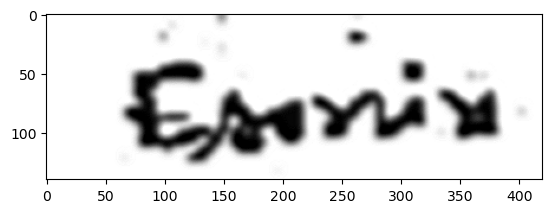

In [ ]:
plt.imshow(train_images[20], cmap = "gray")

In [ ]:
print("Example label:", train_labels.iloc[3])

Example label: IMAGE                  3.png
MEDICINE_NAME          Aceta
GENERIC_NAME     Paracetamol
Name: 3, dtype: object


### Validation data

#### validation Labels

In [ ]:
validation_path = "./Dataset/archive/dataset/Validation"
validation_labels = pd.read_csv(os.path.join(validation_path,"validation_labels.csv"), delimiter = ",")

In [ ]:
validation_labels.head()

,IMAGE,MEDICINE_NAME,GENERIC_NAME
0,0.png,Aceta,Paracetamol
1,1.png,Aceta,Paracetamol
2,2.png,Aceta,Paracetamol
3,3.png,Aceta,Paracetamol
4,4.png,Aceta,Paracetamol


##### Encode the medecine name

In [ ]:
validation_name_enc = to_categorical(medicine_enc.transform(validation_labels["MEDICINE_NAME"]), num_classes=78)
# validation_labels["MEDECINE_NAME_ENC"] = validation_name_enc

In [ ]:
type(validation_name_enc)

numpy.ndarray

In [ ]:
len(validation_labels["MEDICINE_NAME"].unique())

78

#### Validation Images

In [ ]:
validation_images = []
validation_files = glob.glob("./Dataset/archive/dataset/Validation/validation_words/*.png")
for picture in validation_files:
    image = cv2.resize(cv2.imread(picture, cv2.IMREAD_GRAYSCALE), (img_width, img_height))

    #since cv2 sometimes return a "none" type we will append the data after validating it if it is a not "none" type
    if image is None:
        print(f"Err importing picture {picture}")
        continue
    #apply adaptive treshold
    image = cv2.adaptiveThreshold(image,
                                         255, # the max value
                                         cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY, #the treshold we are using
                                         41, #how many pixels to look at
                                         10 #noise reduction
                                         )

    #sharpening the image
    # Create the sharpening kernel
    kernel = np.array([[-1, -1, 1],
                        [-1,  8, -1],
                        [-1, -2, -1]])

    #increase the contrast
    clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(7,7))
    image = clahe.apply(image)

    #blur the image so that the lines are more defined
    image = cv2.GaussianBlur(image, (7,7), 20)
    image = cv2.GaussianBlur(image, (7,7), 20)
    image = cv2.GaussianBlur(image, (7,7), 20)

    # Sharpen the image
    image = cv2.filter2D(image, -1, kernel)


    validation_images.append(image)
    # image = np.asarray(image) # for numpy 1.23

    # To show the images
    # plt.imshow(image, cmap = "gray")
    # plt.show()

validation_images = np.array(validation_images)
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

# Shuffling the data
BUFFER_SIZE = len(validation_images)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE)

In [ ]:
print("Dataset shape:", validation_images.shape)
print("Labels shape:", validation_labels.shape)

Dataset shape: (780, 140, 420)
Labels shape: (780, 3)


##### Check if it is correct

In [ ]:
validation_images[0]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

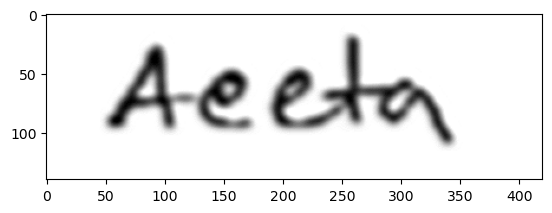

In [ ]:
plt.imshow(validation_images[0], cmap = "gray")

In [ ]:
print("Example label:", validation_labels.iloc[0])

Example label: IMAGE                  0.png
MEDICINE_NAME          Aceta
GENERIC_NAME     Paracetamol
Name: 0, dtype: object


### Test data

#### Test Labels

In [ ]:
test_path = "./Dataset/archive/dataset/Testing"
test_labels = pd.read_csv(os.path.join(test_path,"testing_labels.csv"), delimiter = ",")

In [ ]:
test_labels.head()

,IMAGE,MEDICINE_NAME,GENERIC_NAME
0,0.png,Aceta,Paracetamol
1,1.png,Aceta,Paracetamol
2,2.png,Aceta,Paracetamol
3,3.png,Aceta,Paracetamol
4,4.png,Aceta,Paracetamol


##### Encode the medecine name

In [ ]:
test_name_enc = to_categorical(medicine_enc.transform(test_labels["MEDICINE_NAME"]), num_classes=78)
# test_labels["train_medecine_name_enc"] = test_name_enc

In [ ]:
len(test_labels["MEDICINE_NAME"].unique())

78

#### Testing Images

In [ ]:
test_images = []
test_files = glob.glob("./Dataset/archive/dataset/Testing/testing_words/*.png")
for picture in test_files:
    image = cv2.resize(cv2.imread(picture, cv2.IMREAD_GRAYSCALE), (img_width, img_height))

    #since cv2 sometimes return a "none" type we will append the data after validating it if it is a not "none" type
    if image is None:
        print(f"Err importing picture {picture}")
        continue
    #apply adaptive treshold
    image = cv2.adaptiveThreshold(image,
                                         255, # the max value
                                         cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY, #the treshold we are using
                                         41, #how many pixels to look at
                                         10 #noise reduction
                                         )

    #sharpening the image
    # Create the sharpening kernel
    kernel = np.array([[-1, -1, 1],
                        [-1,  8, -1],
                        [-1, -2, -1]])

    #increase the contrast
    clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(7,7))
    image = clahe.apply(image)

    #blur the image so that the lines are more defined
    image = cv2.GaussianBlur(image, (7,7), 20)
    image = cv2.GaussianBlur(image, (7,7), 20)
    image = cv2.GaussianBlur(image, (7,7), 20)

    # Sharpen the image
    image = cv2.filter2D(image, -1, kernel)

    test_images.append(image)
    # image = np.asarray(image) # for numpy 1.23

    # To show the images
    # plt.imshow(image, cmap = "gray")
    # plt.show()

test_images = np.array(test_images)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Shuffling the data
BUFFER_SIZE = len(test_images)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)

In [ ]:
print("Dataset shape:", test_images.shape)
print("Labels shape:", test_labels.shape)

Dataset shape: (780, 140, 420)
Labels shape: (780, 3)


##### Check if it is correct

In [ ]:
test_images[0].shape

(140, 420)

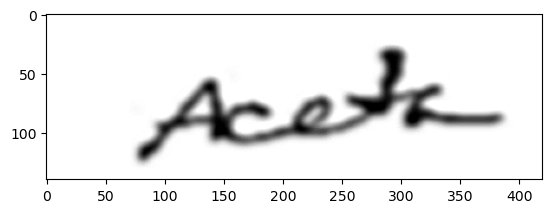

In [ ]:
plt.imshow(test_images[0], cmap = "gray")

In [ ]:
print("Example label:", test_labels.iloc[0])

Example label: IMAGE                  0.png
MEDICINE_NAME          Aceta
GENERIC_NAME     Paracetamol
Name: 0, dtype: object


## Building the artificial neural network

#### Make a model create function

##### Parameters for the model

In [ ]:
#number of classes to determine how many neurons are in the output layer
num_classes = len(train_labels["MEDICINE_NAME"].unique())
num_classes

78

In [ ]:
#the image size to determine the shape for the convolutional neural network to scan
train_images[0].shape

(140, 420)

#### Custom metric

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return keras.backend.cast(recall, "float16")

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return keras.backend.cast(precision, "float16")

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    f1 = 2*((precision*recall)/(precision+recall+K.epsilon()))
    return keras.backend.cast(f1, "float16")

#### Create a model builder for gridsearch

the even filter shapes aren't recommended because it lacks the ability to devide the previous layer pixels arould the output pixel <a hre = "https://medium.com/analytics-vidhya/how-to-choose-the-size-of-the-convolution-filter-or-kernel-size-for-cnn-86a55a1e2d15">(Pandey, 2020)</a>.

<a href = "https://medium.com/@nerdjock/convolutional-neural-network-lesson-9-activation-functions-in-cnns-57def9c6e759">Machine Learning in Plain English (2023)</a> The most common activation functions are "relu" and "leaky relu" therefore we would pass it in the grid search.

Max pooling excells in image classification, due to how max pooling captures the most prominent features and reduce the variance of the input <a href = "https://www.linkedin.com/advice/1/how-do-you-choose-appropriate-pooling-method-2uvmc#adaptive-pooling">(Awad et. al, n.d.)</a>.

In [ ]:
# Model Parameters to Grid Search
params_space = {
    "filter_choice" : hp.choice("filter_choice", [32, 64, 128]),
    "kernel_size" : hp.choice("kernel_size", [3, 5, 7]),
    "n_neurons" : hp.choice("n_neurons", [256, 512, 1024]),
    "learning_rate": hp.uniform("learning_rate",0.001,1),
    "activation" : hp.choice("activation",['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', 'softmax']),
    "n_conv_layers": hp.choice("n_conv_layers", [1, 3]),
    "n_pool_layers": hp.choice("n_pool_layers", [1, 2, 3]),
    "dense_optimizer": hp.choice('optimizer', ['adam', 'sgd', 'rmsprop']),
    "dropout_rate": hp.uniform("dropout_rate", 0.1, 0.5)
}

In [ ]:
def create_model(params):
    input_shape = (img_height, img_width, 1)
    model = Sequential()
    metrics = ['accuracy', recall_m, precision_m]

    # Input layer
    model.add(layers.Conv2D(
        filters = params["filter_choice"],
        kernel_size = params["kernel_size"],
        activation= params["activation"],
        input_shape=input_shape
    ))
    model.add(layers.MaxPooling2D(pool_size=2))

    # Convolutional layers
    for i in range(params["n_conv_layers"]):
        model.add(layers.Conv2D(
            filters= params["filter_choice"],
            kernel_size = params["kernel_size"],
            activation= params["activation"]
        ))
        if i < params["n_pool_layers"]:
            model.add(layers.MaxPooling2D(pool_size=2))

    # drop out layers to prevent overfitting
    model.add(layers.Dropout(params['dropout_rate']))

    # Flatten layer
    model.add(layers.Flatten())

    # Intermediate dense layer
    model.add(layers.Dense(
        params["n_neurons"],
        activation= params["activation"]
    ))

    # another drop out layers to prevent overfitting
    model.add(layers.Dropout(params['dropout_rate']))

    # Output layer (78 classes)
    model.add(layers.Dense(78, activation="softmax"))

    # Optimizer selection
    optimizer_name = params["dense_optimizer"]
    if optimizer_name == 'adam': #dynamic learning rate
        optimizer = tf.keras.optimizers.Adam(learning_rate = params["learning_rate"])
    elif optimizer_name == 'sgd': #static learning rate
        optimizer = tf.keras.optimizers.SGD(learning_rate = params["learning_rate"])
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate = params["learning_rate"])

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics = metrics)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      mode = 'min', #to match the fmin function from hyperopt
                                                                    #we will search for the model with the least loss
                                                      verbose=1,
                                                      patience=3)

    model.fit(train_images, train_name_enc,
              validation_data=(validation_images, validation_name_enc),
              callbacks=[early_stopping])

    loss, accuracy, recall, precision = model.evaluate(validation_images, validation_name_enc)
    print(f"validation Accuracy: {accuracy}")
    print(f"validation recall: {recall}")
    print(f"validation precision: {precision}")
    return {
        'loss' : loss,
        'status' :STATUS_OK,
        'model' : model,
        'params' : params
    }

In this project, a hyperopt gridsearch will be implemented as reference to <a href = "https://medium.com/@icaro_vazquez/neural-network-hyperparameter-optimization-with-hyperopt-f3e0cb4346c8">(Icaro, 2024)</a>.

In [ ]:
# initialize trials to keep the history of every trial
trial =  Trials()

#### Start the grid search

In [ ]:
best_params = fmin(
    fn = create_model,
    space = params_space,
    algo = tpe.suggest, #bayesian optimization
    max_evals= 200, #number of models to try
    trials= trial
)

98/98 [==============================] - 121s 1s/step - loss: 399.4293 - accuracy: 0.0128 - recall_m: 0.0128 - precision_m: 0.0128 - val_loss: 311.0947 - val_accuracy: 0.0128 - val_recall_m: 0.0125 - val_precision_m: 0.0125

25/25 [==============================] - 9s 348ms/step - loss: 311.0947 - accuracy: 0.0128 - recall_m: 0.0125 - precision_m: 0.0125

validation Accuracy: 0.012820512987673283              
validation recall: 0.012500000186264515                
validation precision: 0.012500000186264515             
98/98 [==============================] - 182s 2s/step - loss: 4.6709 - accuracy: 0.0119 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - val_loss: 4.5959 - val_accuracy: 0.0128 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00

25/25 [==============================] - 16s 634ms/step - loss: 4.5959 - accuracy: 0.0128 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00

validation Accuracy: 0.012820512987673283                                           
validation r

job exception: Graph execution error:

Detected at node 'RMSprop/RMSprop/update_4/Square' defined at (most recent call last):
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Panther\

  6%|▋         | 13/200 [1:37:11<23:18:00, 448.56s/trial, best loss: 4.5267558097839355]


ResourceExhaustedError: Graph execution error:

Detected at node 'RMSprop/RMSprop/update_4/Square' defined at (most recent call last):
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Panther\AppData\Local\Temp\ipykernel_20716\778908521.py", line 1, in <module>
      best_params = fmin(
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\hyperopt\fmin.py", line 540, in fmin
      return trials.fmin(
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\hyperopt\base.py", line 671, in fmin
      return fmin(
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\hyperopt\fmin.py", line 586, in fmin
      rval.exhaust()
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\hyperopt\fmin.py", line 364, in exhaust
      self.run(self.max_evals - n_done, block_until_done=self.asynchronous)
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\hyperopt\fmin.py", line 300, in run
      self.serial_evaluate()
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\hyperopt\fmin.py", line 178, in serial_evaluate
      result = self.domain.evaluate(spec, ctrl)
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\hyperopt\base.py", line 892, in evaluate
      rval = self.fn(pyll_rval)
    File "C:\Users\Panther\AppData\Local\Temp\ipykernel_20716\846914089.py", line 60, in create_model
      model.fit(train_images, train_name_enc,
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 579, in minimize
      return self.apply_gradients(grads_and_vars, name=name)
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 738, in apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 797, in _distributed_apply
      update_op = distribution.extended.update(
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 776, in apply_grad_to_update_var
      update_op = self._resource_apply_dense(grad, var, **apply_kwargs)
    File "c:\Users\Panther\anaconda3\envs\dl_env\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py", line 226, in _resource_apply_dense
      ] * tf.square(grad)
Node: 'RMSprop/RMSprop/update_4/Square'
OOM when allocating tensor with shape[384000,2048] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[{{node RMSprop/RMSprop/update_4/Square}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_32140]